In [8]:
#initialization
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

lambda_ = 0.05
beta = 0.1   
k = 1         
sig=1
M=50
m=4
num_trajectories = 1000  # Number of trajectories


def s(j,delta_t,s_0):
    mean=s_0 * np.exp(lambda_ * j * delta_t)
    variance=(np.exp(2* lambda_ * j * delta_t) -1)*sig**2/(2*lambda_)
    return np.random.normal(mean,np.sqrt(variance))
    
# Reward function
def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * s * (-3 * k * np.cos(k * s)**2 * np.sin(k * s))
    reward -= (sig**2/2)*(6 * k**2 * np.cos(s) * np.sin(k*s)**2 - 3* k**2 * np.cos(k*s)**3)
    return reward
    
# Define periodic bases
def bases(s):
    bases=[1/np.sqrt(2*np.pi)]
    for m in range(1,M+1):
        bases.append(np.cos(m*s)/np.sqrt(np.pi))
        bases.append(np.sin(m*s)/np.sqrt(np.pi))
    return np.array(bases).reshape(-1,1)   #return column vector

def gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
        gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)  

def gra_gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m**2*np.cos(m*s)/np.sqrt(np.pi))
        gradient_bases.append(-m**2*np.sin(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)



s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)



In [9]:

#compute
stepsizes=[1e-3,1e-2,10e-1,1,10]
error_PhiBE=[]
error_PhiBE_2nd=[]
error_BFF=[]
error_BFF_2nd=[]
for delta_t in stepsizes:
    trajectories = []
    for s_0 in s_0_values:
        traj = [s_0]
        for j in range(m+1):
            s_now = traj[-1]
            s_next = s(1,delta_t,s_now)    
            traj.append(s_next)
        trajectories.append(traj)
    #solution to 1-st order PhiBE
    A = np.zeros((2 * M + 1, 2 * M + 1))
    b = np.zeros((2 * M + 1, 1))

    for traj in trajectories:
        for j in range(m):
            s_j = traj[j]
            mu = ((np.exp(lambda_*delta_t)-1)*s_j) / delta_t
            sigma=( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (np.exp(lambda_*delta_t)-1)**2 * s_j**2 )/ delta_t
            A += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
            b += reward_function(s_j)*bases(s_j)

    theta = np.linalg.solve(A, b)

    PhiBE_1st_values = []
    error=0
    for s_0 in s_0_values:
        a = theta.T @ bases(s_0)
        PhiBE_1st_values.append(a.item())
        error+=(a-np.cos(k*s_0)**3)**2*2*np.pi/num_trajectories
    error_PhiBE.append(np.sqrt(error).item())

    #solution to 2nd order PhiBE
    A11 = np.zeros((2 * M + 1, 2 * M + 1))
    b11 = np.zeros((2 * M + 1, 1))

    for traj in trajectories:
        for j in range(m):
            s_j = traj[j]
            mu = 2*((np.exp(lambda_*delta_t)-1)*s_j) -(1/2)*((np.exp(2*lambda_*delta_t)-1)*s_j)
            mu=mu/ delta_t
            sigma= 2*( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (np.exp(lambda_*delta_t)-1)**2 * s_j**2 )
            sigma-=(1/2)*( (sig**2/(2*lambda_)) *(np.exp(4*lambda_*delta_t)-1) + (np.exp(2*lambda_*delta_t)-1)**2 * s_j**2 )
            sigma=sigma/ delta_t
            A11 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
            b11 += reward_function(s_j)*bases(s_j)

    theta11 = np.linalg.solve(A11, b11)

    PhiBE_2nd_values = []
    error=0
    for s_0 in s_0_values:
        a = theta11.T @ bases(s_0)
        PhiBE_2nd_values.append(a.item())
        error+=(a-np.cos(k*s_0)**3)**2*2*np.pi/num_trajectories
    error_PhiBE_2nd.append(np.sqrt(error).item())

    #solution to 1-st order BFF
    A2 = np.zeros((2 * M + 1, 2 * M + 1))
    b2 = np.zeros((2 * M + 1, 1))

    for traj in trajectories:
        for j in range(m):
            s_j = traj[j]
            mu = ((np.exp(lambda_*delta_t)-1)*s_j) / delta_t
            sigma=( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (1-np.exp(lambda_*delta_t))**3 * s_j**2 )/  delta_t
            A2 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
            b2 += reward_function(s_j)*bases(s_j)

    theta2 = np.linalg.solve(A2, b2)

    BFF_1st_values = []
    error=0
    for s_0 in s_0_values:
        a = theta2.T @ bases(s_0)
        BFF_1st_values.append(a.item())
        error+=(a-np.cos(k*s_0)**3)**2*2*np.pi/num_trajectories
    error_BFF.append(np.sqrt(error).item())

    #solution to 2nd order BFF 
    A20 = np.zeros((2 * M + 1, 2 * M + 1))
    b20 = np.zeros((2 * M + 1, 1))

    for traj in trajectories:
        for j in range(m):
            s_j = traj[j]
            mu = 2*((np.exp(lambda_*delta_t)-1)*s_j) -(1/2)*((np.exp(2*lambda_*delta_t)-1)*s_j)
            mu=mu/ delta_t
            sigma= 2*( (sig**2/(2*lambda_)) *(np.exp(2*lambda_*delta_t)-1) + (1-np.exp(lambda_*delta_t))**3 * s_j**2 )
            sigma-=(1/2)*( (sig**2/(2*lambda_)) *(np.exp(4*lambda_*delta_t)-1) + (np.exp(2*lambda_*delta_t)-1)**2 * s_j**2 )
            sigma-=(1/2) * s_j**2 * (1-np.exp(2*lambda_*delta_t))*(np.exp(lambda_*delta_t)+np.exp(3*lambda_*delta_t)-np.exp(2*lambda_*delta_t)-1)
            sigma=sigma/ delta_t
            A20 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j)-(sigma/2) * gra_gradient_bases(s_j)).T
            b20 += reward_function(s_j)*bases(s_j)

    theta20 = np.linalg.solve(A20, b20)

    BFF_2nd_values = []
    error=0
    for s_0 in s_0_values:
        a = theta20.T @ bases(s_0)
        BFF_2nd_values.append(a.item())
        error+=(a-np.cos(k*s_0)**3)**2*2*np.pi/num_trajectories
    error_BFF_2nd.append(np.sqrt(error).item())




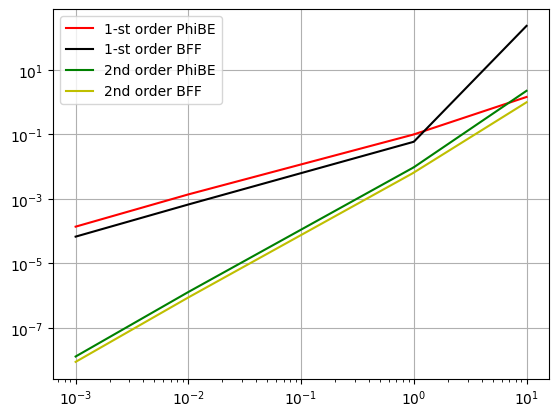

In [11]:
#plot together
plt.loglog(stepsizes,error_PhiBE,'r-', label='1-st order PhiBE')
plt.loglog(stepsizes,error_BFF,'k-', label='1-st order BFF')
plt.loglog(stepsizes,error_PhiBE_2nd,'g-', label='2nd order PhiBE')
plt.loglog(stepsizes,error_BFF_2nd,'y-', label='2nd order BFF ')

plt.grid()
plt.legend()
plt.show()